In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import shutil
from tensorflow.keras.layers import Dropout

In [33]:
# Load images and labels
data_dir = "/content/data"
cataract_dir = os.path.join(data_dir, "Cataract")
normal_dir = os.path.join(data_dir, "Normal")

cataract_images = [os.path.join(cataract_dir, img) for img in os.listdir(cataract_dir)]
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
total_images = cataract_images + normal_images
labels = ["cataract"] * len(cataract_images) + ["normal"] * len(normal_images)

In [34]:
# Split data into train, validation, and test sets
train_images, test_images, train_labels, test_labels = train_test_split(total_images, labels, test_size=0.1, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [35]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [36]:
data_dir = "/content/data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(directory, "Cataract"), exist_ok=True)
    os.makedirs(os.path.join(directory, "Normal"), exist_ok=True)

def move_images(images, labels, destination_dir):
    for img_path, label in zip(images, labels):
        if label == "cataract":
            shutil.copy(img_path, os.path.join(destination_dir, "Cataract"))
        elif label == "normal":
            shutil.copy(img_path, os.path.join(destination_dir, "Normal"))

move_images(train_images, train_labels, train_dir)
move_images(val_images, val_labels, val_dir)
move_images(test_images, test_labels, test_dir)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 562 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [37]:
def build_bcnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

In [38]:
# Build model
model = build_bcnn((150, 150, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [39]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=100, verbose=1)

Epoch 1/100
18/18 [==============================] - 12s 264ms/step - loss: 0.6970 - accuracy: 0.5587 - val_loss: 0.6578 - val_accuracy: 0.6241
Epoch 2/100
18/18 [==============================] - 5s 309ms/step - loss: 0.6578 - accuracy: 0.6228 - val_loss: 0.6818 - val_accuracy: 0.6241
Epoch 3/100
18/18 [==============================] - 5s 300ms/step - loss: 0.6795 - accuracy: 0.5836 - val_loss: 0.6631 - val_accuracy: 0.6525
Epoch 4/100
18/18 [==============================] - 4s 240ms/step - loss: 0.6488 - accuracy: 0.6459 - val_loss: 0.6290 - val_accuracy: 0.6454
Epoch 5/100
18/18 [==============================] - 4s 235ms/step - loss: 0.6541 - accuracy: 0.6281 - val_loss: 0.6506 - val_accuracy: 0.6312
Epoch 6/100
18/18 [==============================] - 5s 297ms/step - loss: 0.6392 - accuracy: 0.6584 - val_loss: 0.6635 - val_accuracy: 0.5887
Epoch 7/100
18/18 [==============================] - 5s 299ms/step - loss: 0.6417 - accuracy: 0.6370 - val_loss: 0.6186 - val_accuracy: 0.652

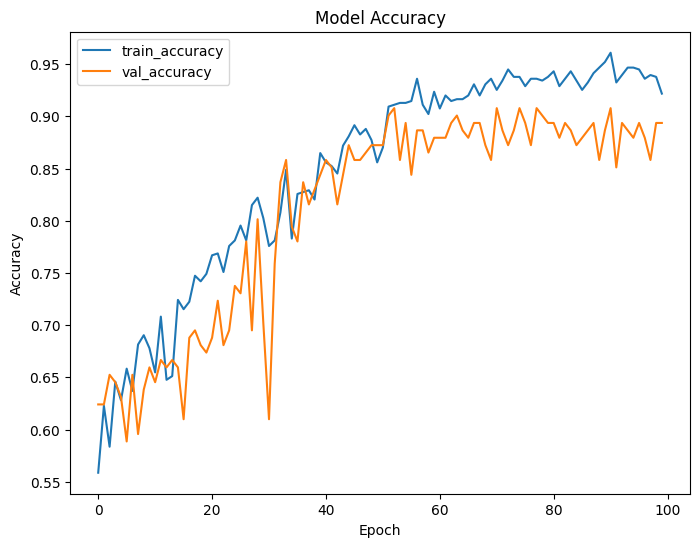

In [47]:
# Plot model accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.savefig('accuracy.png')
plt.legend()
plt.show()

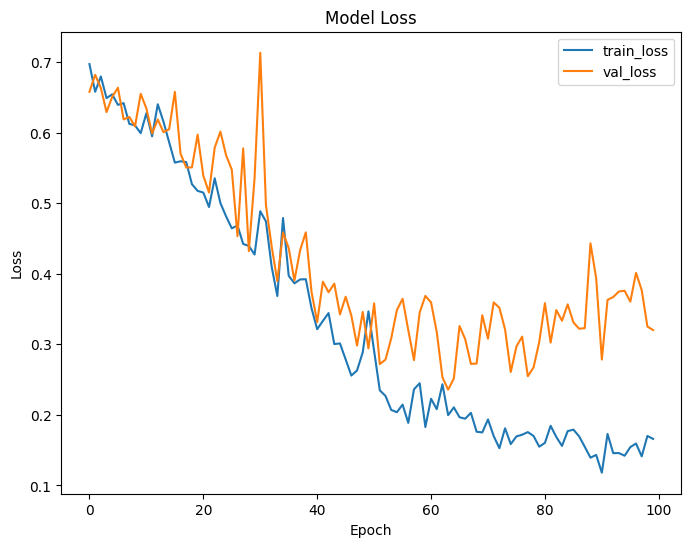

In [48]:
# Plot model loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [43]:
# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

3/3 [==============================] - 1s 209ms/step - loss: 0.1057 - accuracy: 0.9494
Test Loss: 0.1057
Test Accuracy: 0.9494


1/1 [==============================] - 0s 20ms/step


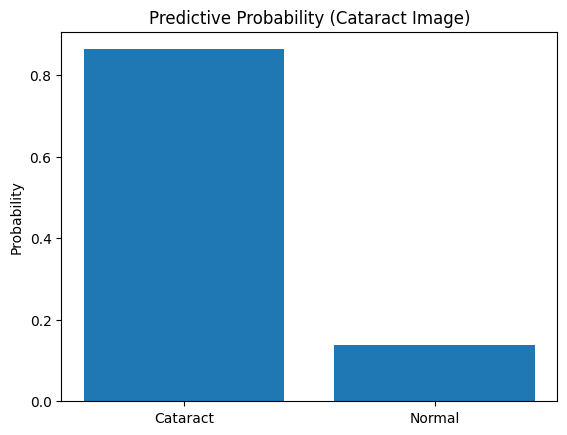

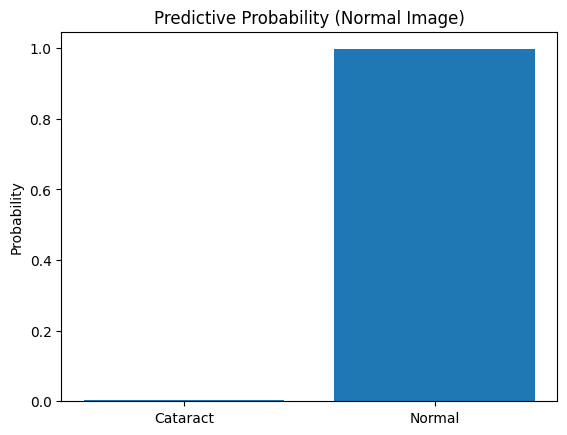

In [54]:
# Select sample images
sample_cataract_img = np.random.choice(cataract_images)
sample_normal_img = np.random.choice(normal_images)

# Load and preprocess sample images
def load_and_preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)
    return img_array

sample_cataract_img_array = load_and_preprocess_image(sample_cataract_img)
sample_normal_img_array = load_and_preprocess_image(sample_normal_img)

# Predict probabilities for sample images
cataract_prob = model.predict(sample_cataract_img_array)[0][0]
normal_prob = model.predict(sample_normal_img_array)[0][0]

plt.bar(['Cataract', 'Normal'], [cataract_prob, 1 - cataract_prob])
plt.title('Predictive Probability (Cataract Image)')
plt.ylabel('Probability')
plt.savefig('Cataract Sample.png')
plt.show()

plt.bar(['Cataract', 'Normal'], [1 - normal_prob, normal_prob])
plt.title('Predictive Probability (Normal Image)')
plt.ylabel('Probability')
plt.savefig('Normal Sample.png')
plt.show()